In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import namedtuple, deque
from IPython import display
# pip install git+https://github.com/jakevdp/JSAnimation.git
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
%load_ext autoreload
%autoreload

In [2]:
env = gym.make('CartPole-v1')
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Actions: 2
Raw observation space: (4,)
Max episode steps: 500


((4,), 1.0)
count    4.000000
mean     0.020840
std      0.210435
min     -0.210935
25%     -0.081931
50%     -0.000440
75%      0.102331
max      0.295177
dtype: float64


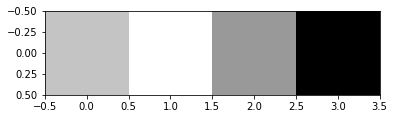

In [3]:
def test(env):
    state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    print(state.shape, reward)
    print(pd.Series(state).describe())
    plt.imshow(state.reshape((1, len(state))), cmap='Greys')

test(env)

In [63]:
class LearningParameters:
    def __init__(self, env, state, episodes_count):
        self.state_shape = state.shape
        self.state_size = np.prod(self.state_shape)
        self.action_size = env.action_space.n
        self.episodes_count = episodes_count
        self.max_frame_in_episode = env.spec.max_episode_steps
        self.max_memory_size = 100000
        self.episodes_between_think = 1
        self.episodes_warmup = 5
        self.show_output_count = 20

        self.gamma = 0.95                # rewards discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model
        self.batch_size = 32
        
        self.reward_is_time = False
        self.discount_rewards = True
        self.normalize_rewards = True

def decay_exploration_rate(params, episode):
    # Exponential rate decay
    # y(0) = start
    # y(1) = start * x
    # y(2) = start * x^2
    # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
    # y(t) = start * x^t
    x = math.pow(params.epsilon_min / params.epsilon_start, 1.0 / params.episodes_count)
    params.epsilon = params.epsilon_start * math.pow(x, episode)

def set_rewards_time(episode_rewards):
    for i in range(len(episode_rewards)):
        episode_rewards[i] = len(episode_rewards) - i

def set_discount_rewards(episode_rewards):
    discounted_reward = 0.0
    for i in reversed(range(len(episode_rewards))):
        reward = episode_rewards[i]
        if params.pong_reset_discounted_reward and reward != 0:
            discounted_reward = 0.0
        discounted_reward = reward + discounted_reward * params.gamma
        episode_rewards[i] = discounted_reward
        
def get_normalized_rewards(episode_rewards):
    episode_rewards -= np.mean(episode_rewards)
    std = np.std(episode_rewards)
    if std != 0:
        episode_rewards /= std
    return episode_rewards
        
def train(session, env, agent, params):
    rewards = []

    for episode in range(params.episodes_count):
        state = env.reset()

        replays = []

        for frame in range(params.max_frame_in_episode):
            action = agent.act(session, state, frame)

            next_state, reward, done, _ = env.step(action)

            if done:
                break

            replays.append((frame, state, action, reward, next_state))
            state = next_state

        episode_rewards = list(r[3] for r in replays)
        rewards.append(sum(episode_rewards))
        
        if params.reward_is_time:
            set_rewards_time(episode_rewards)
        if params.discount_rewards:
            set_discount_rewards(episode_rewards)
        if params.normalize_rewards:
            episode_rewards = get_normalized_rewards(episode_rewards)

        for i in range(len(replays)):
            frame, state, action, _, next_state = replays[i]
            agent.remember(state, action, episode_rewards[i], next_state, frame)

        if params.show_output_count is not None and \
            (episode + 1) % max(1, (params.episodes_count / params.show_output_count)) == 0:
            print("Episode: {}/{}, reward {}, frames {}, exploration rate: {:.2}".format(
                episode + 1,
                params.episodes_count,
                np.mean(rewards[-10:]),
                len(replays),
                params.epsilon))

        if episode > params.episodes_warmup and (episode + 1) % params.episodes_between_think == 0:
            agent.think(session, params.batch_size, episode)

        decay_exploration_rate(params, episode)

    return agent, rewards

# https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
# Input: state, action OHE
# Output: Q reward
class DqnAgentModified:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.a = tf.placeholder("int32", [None], name="Placeholder_a")
        self.y = tf.placeholder("float", [None], name="Placeholder_y")
        
        actions_ohe = tf.one_hot(self.a, depth=self.params.action_size, axis=-1)
        print('actions_ohe:', actions_ohe)

        inp = tf.concat([actions_ohe, self.x], axis=1)
        print('inp', inp)
        
        fc1 = tf.contrib.layers.fully_connected(
            inp,
            12,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('fc1', fc1)
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.pred', self.pred)
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.pred, self.y))
        print('self.cost', self.cost)

        self.train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state, state], self.a: [0, 1]})
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        a0 = np.zeros(cnt, dtype='int32')
        a1 = np.ones(cnt, dtype='int32')
        
        nextValues = np.zeros((cnt, self.params.action_size))
        nextValues[:,0] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a0})[:,0]
        nextValues[:,1] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a1})[:,0]
        
        Y = self.memory_rewards[:cnt] + self.params.gamma * np.amax(nextValues, axis=1)
        
        cost_before = session.run(self.cost, {
            self.x: self.memory_states[:cnt],
            self.a: self.memory_actions[:cnt],
            self.y: Y})
        
        cost_after = cost_before
        for epoch in range(20):
            
            P = np.random.permutation(cnt)
            for i in range(0, len(P), batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = self.memory_states[batch_indexes, :]
                batch_a = self.memory_actions[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(self.train_op, {
                    self.x: batch_x,
                    self.a: batch_a,
                    self.y: batch_y})
            
            cost_curr = session.run(self.cost, {
                self.x: self.memory_states[:cnt],
                self.a: self.memory_actions[:cnt],
                self.y: Y})
            
            if cost_curr > cost_after:  # early stopping
                break
            
            cost_after = cost_curr
            
#         print("Dataset {}, epochs {}, cost: {} --> {}".format(cnt, epoch, cost_before, cost_after))

('actions_ohe:', <tf.Tensor 'one_hot:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('fc1', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 12) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'Mean:0' shape=() dtype=float32>)
Episode: 15/300, reward 22.2, frames 16, exploration rate: 0.88
Episode: 30/300, reward 18.1, frames 9, exploration rate: 0.76
Episode: 45/300, reward 22.8, frames 16, exploration rate: 0.65
Episode: 60/300, reward 31.6, frames 56, exploration rate: 0.56
Episode: 75/300, reward 27.8, frames 13, exploration rate: 0.48
Episode: 90/300, reward 31.6, frames 10, exploration rate: 0.42
Episode: 105/300, reward 53.2, frames 61, exploration rate: 0.36
Episode: 120/300, reward 40.8, frames 58, exploration rate: 0.31
Episode: 135/300, reward 49.9, frames 45, exploration rate: 0.26
Episode: 150/300, reward 45.0, frames 10, exploration rate: 0.23
Episode: 165

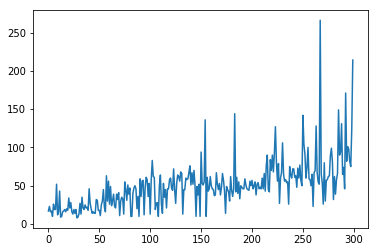

In [6]:
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=300)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.1
params.epsilon_min = 0.05
params.max_memory_size = 10000
params.pong_reset_discounted_reward = False
params.reward_is_time = False
params.discount_rewards = True
params.normalize_rewards = True
agent = DqnAgentModified(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

    agent, rewards = train(session, env, agent, params)
    
    plt.plot(rewards)

In [7]:
# Input: state, action OHE
# Output: next state, Q reward on state
# Train: (state, action) ~ (next state, Q reward on state)
class DqnAgentPredictFuture:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.xnext = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_xnext")
        self.a = tf.placeholder("int32", [None], name="Placeholder_a")
        self.y = tf.placeholder("float", [None], name="Placeholder_y")
        
        actions_ohe = tf.one_hot(self.a, depth=self.params.action_size, axis=-1)
        print('actions_ohe:', actions_ohe)

        inp = tf.concat([actions_ohe, self.x], axis=1)
        print('inp', inp)
        
        inner = tf.contrib.layers.fully_connected(
            inp,
            12,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('inner', inner)
        
        self.prednext = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=self.params.state_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.prednext', self.prednext)
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.pred', self.pred)
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.pred, self.y)) +\
            tf.reduce_mean(tf.squared_difference(self.prednext, self.xnext))
        print('self.cost', self.cost)

        self.train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state, state], self.a: [0, 1]})
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        a0 = np.zeros(cnt, dtype='int32')
        a1 = np.ones(cnt, dtype='int32')

        nextValues = np.zeros((cnt, self.params.action_size))
        nextValues[:,0] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a0})[:,0]
        nextValues[:,1] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: a1})[:,0]

        Y = self.memory_rewards[:cnt] + self.params.gamma * np.amax(nextValues, axis=1)

        cost_before = session.run(self.cost, {
            self.x: self.memory_states[:cnt],
            self.xnext: self.memory_next_states[:cnt],
            self.a: self.memory_actions[:cnt],
            self.y: Y})

        cost_after = cost_before
        for epoch in range(20):

            P = np.random.permutation(cnt)
            for i in range(0, len(P), batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = self.memory_states[batch_indexes, :]
                batch_xnext = self.memory_next_states[batch_indexes, :]
                batch_a = self.memory_actions[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(self.train_op, {
                    self.x: batch_x,
                    self.xnext: batch_xnext[:cnt],
                    self.a: batch_a,
                    self.y: batch_y})

            cost_curr = session.run(self.cost, {
                self.x: self.memory_states[:cnt],
                self.xnext: self.memory_next_states[:cnt],
                self.a: self.memory_actions[:cnt],
                self.y: Y})

            if cost_curr > cost_after:  # early stopping
                break

            cost_after = cost_curr

        if (episode + 1) % max(1, (self.params.episodes_count / 20)) == 0:
            print("    dataset {}, epochs {}, cost: {} --> {}".format(cnt, epoch, cost_before, cost_after))

('actions_ohe:', <tf.Tensor 'one_hot:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('inner', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 12) dtype=float32>)
('self.prednext', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 4) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_2/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'add:0' shape=() dtype=float32>)
Episode: 15/300, reward 15.4, frames 14, exploration rate: 0.88
    dataset 281, epochs 0, cost: 1.05201435089 --> 1.05201435089
Episode: 30/300, reward 18.1, frames 9, exploration rate: 0.76
    dataset 571, epochs 1, cost: 1.02507281303 --> 1.02405679226
Episode: 45/300, reward 25.9, frames 36, exploration rate: 0.65
    dataset 908, epochs 0, cost: 1.02916181087 --> 1.02916181087
Episode: 60/300, reward 19.5, frames 28, exploration rate: 0.56
    dataset 1164, epochs 0, cost: 1.03255033493 --> 1.03255033493
Episode: 75/300, reward 25.7, frames 15, explorati

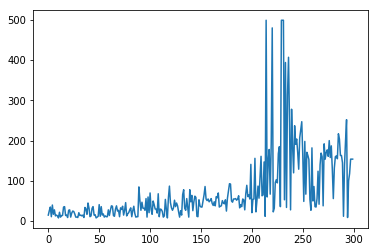

In [8]:
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=300)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.1
params.epsilon_min = 0.05
params.max_memory_size = 10000
params.pong_reset_discounted_reward = False
params.reward_is_time = False
params.discount_rewards = True
params.normalize_rewards = True
agent = DqnAgentPredictFuture(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

    agent, rewards = train(session, env, agent, params)
    
    plt.plot(rewards)

In [64]:
# Input: state, action OHE
# Output: next state, Q reward on state
# Train: (state, action, time delta) ~ (next state after time delta passed, reward)
class DqnAgentPredictDistantFuture:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.xnext = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_xnext")
        self.a = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_a")
        self.y = tf.placeholder("float", [None], name="Placeholder_y")
        
        print('actions_ohe:', self.a)

        inp = tf.concat([self.x, self.a], axis=1)
        print('inp', inp)
        
        inner = tf.contrib.layers.fully_connected(
            inp,
            12,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('inner', inner)
        
        self.prednext = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=self.params.state_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.prednext', self.prednext)
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=inner,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        print('self.pred', self.pred)
        
        self.cost = tf.reduce_mean(tf.squared_difference(self.pred, self.y)) +\
            tf.reduce_mean(tf.squared_difference(self.prednext, self.xnext))
        print('self.cost', self.cost)

        self.train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {
            self.x: [state, state, state, state, state, state],
            self.a: [
                [1., 0.],
                [0., 1.],
                [2., 0.],
                [0., 2.],
                [2., 1.],
                [1., 2.],
            ]})
        return np.argmax(act_values) % 2

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        action0 = np.zeros((cnt, 2))
        action0[:,0] = 1.
        action1 = np.zeros((cnt, 2))
        action1[:,1] = 1.
        
        # TODO: Update Q value with look forward
        nextValues = np.zeros((cnt, self.params.action_size))
        nextValues[:,0] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: action0})[:,0]
        nextValues[:,1] = session.run(self.pred, {self.x: self.memory_next_states[:cnt], self.a: action1})[:,0]

        qrewards = self.memory_rewards[:cnt] + self.params.gamma * np.amax(nextValues, axis=1)

        X = np.concatenate([
            self.memory_states[:cnt],
            self.memory_states[:cnt-1],
            self.memory_states[:cnt-2]], axis=0)
        
        action_len_1 = np.zeros((cnt, self.params.action_size))
        action_len_1[np.arange(cnt), self.memory_actions[:cnt]] = 1.0
        
        action_len_2 = np.zeros((cnt-1, self.params.action_size))
        action_len_2[np.arange(cnt-1), self.memory_actions[:cnt-1]] = 1.0
        action_len_2[np.arange(cnt-1), self.memory_actions[1:cnt]] += 1.0
        
        action_len_3 = np.zeros((cnt-2, self.params.action_size))
        action_len_3[np.arange(cnt-2), self.memory_actions[:cnt-2]] = 1.0
        action_len_3[np.arange(cnt-2), self.memory_actions[1:cnt-1]] += 1.0
        action_len_3[np.arange(cnt-2), self.memory_actions[2:cnt]] += 1.0
        
        A = np.concatenate([
            action_len_1,
            action_len_2,
            action_len_3], axis=0)
        
        XN = np.concatenate([
            self.memory_next_states[:cnt],
            self.memory_next_states[1:cnt],
            self.memory_next_states[2:cnt]], axis=0)
        
        Y = np.concatenate([
            qrewards,
            qrewards[1:cnt],
            qrewards[2:cnt]], axis=0)
        
        cost_before = session.run(self.cost, {
            self.x: X,
            self.xnext: XN,
            self.a: A,
            self.y: Y})
        
        cost_after = cost_before
        for epoch in range(20):

            P = np.random.permutation(cnt)
            for i in range(0, len(P), batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes, :]
                batch_xnext = XN[batch_indexes, :]
                batch_a = A[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(self.train_op, {
                    self.x: batch_x,
                    self.xnext: batch_xnext,
                    self.a: batch_a,
                    self.y: batch_y})

            cost_curr = session.run(self.cost, {
                self.x: X,
                self.xnext: XN,
                self.a: A,
                self.y: Y})

            if cost_curr > cost_after:  # early stopping
                break

            cost_after = cost_curr

        if self.params.show_output_count is not None and \
            (episode + 1) % max(1, (self.params.episodes_count / self.params.show_output_count)) == 0:
            print("    dataset {}, epochs {}, cost: {} --> {}".format(cnt, epoch, cost_before, cost_after))

('actions_ohe:', <tf.Tensor 'Placeholder_a:0' shape=(?, 2) dtype=float32>)
('inp', <tf.Tensor 'concat:0' shape=(?, 6) dtype=float32>)
('inner', <tf.Tensor 'fully_connected/Relu:0' shape=(?, 12) dtype=float32>)
('self.prednext', <tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 4) dtype=float32>)
('self.pred', <tf.Tensor 'fully_connected_2/BiasAdd:0' shape=(?, 1) dtype=float32>)
('self.cost', <tf.Tensor 'add:0' shape=() dtype=float32>)
Episode: 10/300, reward 21.6, frames 38, exploration rate: 0.92
    dataset 216, epochs 0, cost: 1.3520731926 --> 1.3520731926
Episode: 20/300, reward 23.9, frames 23, exploration rate: 0.84
    dataset 455, epochs 0, cost: 1.25956583023 --> 1.25956583023
Episode: 30/300, reward 22.4, frames 24, exploration rate: 0.76
    dataset 679, epochs 2, cost: 1.24903106689 --> 1.14758682251
Episode: 40/300, reward 27.5, frames 11, exploration rate: 0.68
    dataset 954, epochs 0, cost: 1.16034376621 --> 1.16034376621
Episode: 50/300, reward 20.7, frames 14, explo

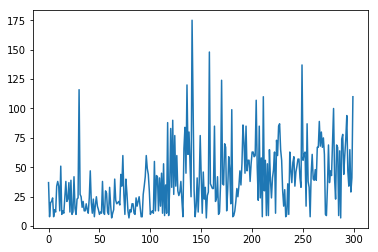

In [80]:
%%time
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=300)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.1
params.epsilon_min = 0.05
params.max_memory_size = 2000
params.pong_reset_discounted_reward = False
params.reward_is_time = False
params.discount_rewards = True
params.normalize_rewards = True
params.show_output_count = 30
agent = DqnAgentPredictDistantFuture(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

stats_avg_rewards = []
stats_max_rewards = []
stats_index_over_200 = []

for stat_i in range(1):
    with tf.Session(config=config) as session:
        session.run(tf.global_variables_initializer())

        agent, rewards = train(session, env, agent, params)

        rewards = np.array(rewards)
        stats_avg_rewards.append(np.mean(rewards))
        stats_max_rewards.append(np.max(rewards))
        index_win = np.argmax(rewards >= 200)
        stats_index_over_200.append(1000 if index_win == 0 else index_win)
        print("Run {}: avg reward {}, max reward {}, index win {}".
            format(stat_i, stats_avg_rewards[-1], stats_max_rewards[-1], stats_index_over_200[-1]))
    
    plt.plot(rewards)

print('mean avg reward', np.mean(stats_avg_rewards))
print('mean max reward', np.mean(stats_max_rewards))
print('mean index win ', np.mean(stats_index_over_200))

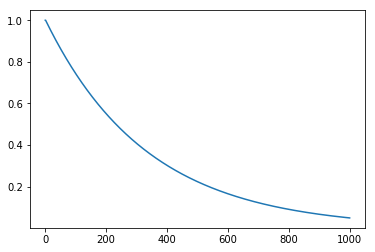

In [76]:
def plot_decay():
    rates = [params.epsilon_start]
    for i in range(params.episodes_count):
        decay_exploration_rate(params, i)
        rates.append(params.epsilon)
    return rates
plt.plot(plot_decay());